# Stock market prediction using LSTM 

The LSTM structure is the following where we have:

$x_t$ = We recieve the input for the cell

$c_{t-1}$ = Previous cell state

$h_{t-1}$ = Output of the previous cell

![LSTM](https://miro.medium.com/max/662/1*mcHP77YF63SuqUGAIiBBsA.jpeg)

**Why LSTM?**

The stock market is the most common example for a time serie because it is 1D data, LSTM is the best of the three most common time series analysis using Deep Learning techinques (GRU and simple RNN). As the stock market involcres money we want a robust sytem. 




#Install and import 

In this section we are going to install and import all the necessry tools for the project

##Lets install some dependencies

In [1]:
#We are going to use the Yahoo Finance library to extract data from the stock market 
pip install yfinance 

     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 6.4 MB 37.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


##Import some libraries

We will import some libraries to crack the code

In [17]:
#Pandas for reading and manipulating some data
import pandas as pd
import pandas_datareader as pdr

#Yahoo Finance to extract stock market data
import yfinance as yf

#Numpy as vector, tensor and matrix manipulation
import numpy as np

#Sklearn, we will use some tools from here 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#Tensorflow and keras for creating the architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

#Math because is useful for some operations
import math

#Matplotlib for plotting beautiful graphs
import matplotlib.pyplot as plt

##Lets create some useful functions 

In [35]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

#Lets observe the data

We will see some graphics that show us the stock market of FAANGs


In [19]:
#Define variables
period = "1mo"
interval = "1d"
start = "2000-01-01" 
end="2021-01-01"

#Tickers 
tickers = yf.Ticker('GOOGL')

hist = tickers.history(period,interval,start,end)
df = pd.DataFrame(hist)
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,4122.000000,4122.000000,4122.000000,4122.000000,4.122000e+03,4122.0,4122.000000
mean,555.729261,561.023230,550.156517,555.732233,6.807283e+06,0.0,0.000485
std,409.554073,413.584294,405.677153,409.819561,7.852185e+06,0.0,0.031120
min,49.644646,50.920921,48.028027,50.055054,4.656000e+05,0.0,0.000000
25%,242.197193,245.132629,239.959961,242.446198,1.806550e+06,0.0,0.000000
50%,352.960449,356.611603,348.936432,351.659149,4.108288e+06,0.0,0.000000
75%,809.235016,813.845001,804.522522,809.652496,8.624417e+06,0.0,0.000000
max,1820.540039,1843.829956,1817.000000,1824.969971,8.215117e+07,0.0,1.998000


We are going to use the 'Close' values because it is the most used in financial markets  

In [21]:
stock_price = df.reset_index()['Close']
stock_price

0         50.220219
1         54.209209
2         54.754753
3         52.487488
4         53.053055
           ...     
4117    1734.160034
4118    1773.959961
4119    1757.760010
4120    1736.250000
4121    1752.640015
Name: Close, Length: 4122, dtype: float64

Lets visualize to see how everything is going on

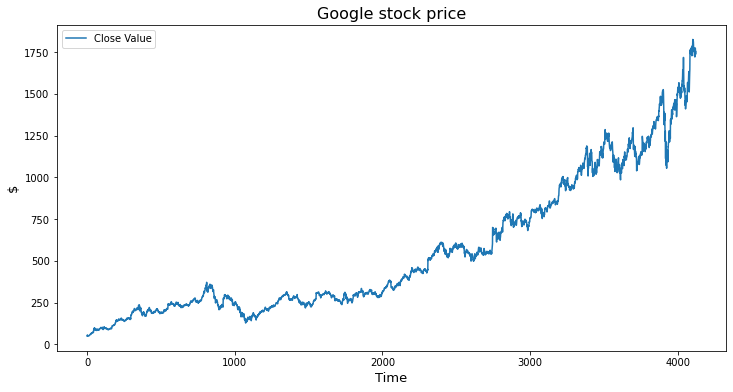

In [24]:
plt.figure(figsize=(12,6))
plt.plot(stock_price, label = "Close Value")
plt.title("Google stock price", fontsize = 16)
plt.ylabel('$', fontsize=13)
plt.xlabel('Time', fontsize=13)
plt.legend()
plt.show()

#Pre Processing

It is extremely useful to preprocess data before training the algorithm. The LSTM is sensible to data that is not between 0 and 1 so we are going to use de **MinMax scaler** to pre-process data to form as an input for the LSTM

**MinMax scaler**

A extremely useful technique to hve data between a range

![minmax](https://i.stack.imgur.com/EuitP.png)


In [26]:
scaler=MinMaxScaler(feature_range=(0,1)) #From 0 to 1
stock_price=scaler.fit_transform(np.array(stock_price).reshape(-1,1))
stock_price[:10]

array([[9.30551352e-05],
       [2.34048161e-03],
       [2.64784489e-03],
       [1.37045109e-03],
       [1.68909567e-03],
       [2.22768797e-03],
       [1.73139248e-03],
       [5.63972535e-04],
       [6.65487033e-04],
       [6.76770481e-05]])

Divide the data in to train set and test set. In this case we are not going to use dev set because the real data is the data is both in the test and train set

In [28]:
training_size=int(len(stock_price)*0.75) #75% for training 
test_size=len(stock_price)-training_size #25% for testing
train_data,test_data=stock_price[0:training_size,:],stock_price[training_size:len(stock_price),:1]
training_size,test_size
train_data

array([[9.30551352e-05],
       [2.34048161e-03],
       [2.64784489e-03],
       ...,
       [4.14073339e-01],
       [4.10692895e-01],
       [4.11385875e-01]])

In [47]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [48]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

(2990, 100)
(2990,)
(930, 100)
(930,)


In [54]:
model=Sequential()
model.add(LSTM(10,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(10,return_sequences=True))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100, 10)           480       
                                                                 
 lstm_19 (LSTM)              (None, 100, 10)           840       
                                                                 
 lstm_20 (LSTM)              (None, 10)                840       
                                                                 
 dense_6 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,171
Trainable params: 2,171
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
47/47 [==============================] - 10s 118ms/step - loss: 0.0067 - val_loss: 0.0024
Epoch 2/10
47/47 [==============================] - 8s 173ms/step - loss: 2.2310e-04 - val_loss: 0.0031
Epoch 3/10
47/47 [==============================] - 6s 127ms/step - loss: 1.5224e-04 - val_loss: 0.0039
Epoch 4/10
47/47 [==============================] - 4s 90ms/step - loss: 1.3505e-04 - val_loss: 0.0058
Epoch 5/10
47/47 [==============================] - 4s 92ms/step - loss: 1.2842e-04 - val_loss: 0.0067
Epoch 6/10
47/47 [==============================] - 6s 122ms/step - loss: 1.2060e-04 - val_loss: 0.0072
Epoch 7/10
47/47 [==============================] - 4s 90ms/step - loss: 1.1978e-04 - val_loss: 0.0075
Epoch 8/10
47/47 [==============================] - 5s 110ms/step - loss: 1.1581e-04 - val_loss: 0.0078
Epoch 9/10
47/47 [==============================] - 4s 86ms/step - loss: 1.1195e-04 - val_loss: 0.0070
Epoch 10/10
47/47 [==============================] - 6s 132ms/step - lo

Test the performance using RMSE

In [51]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
##We will transform again the data to lot it
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
### Performance
math.sqrt(mean_squared_error(y_train,train_predict))

0.009513890554486712

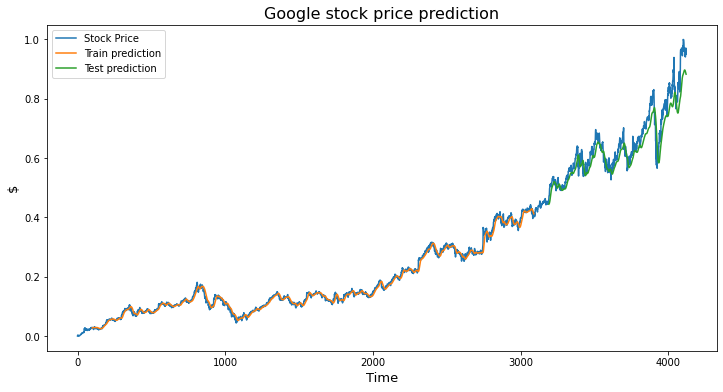

In [58]:
look_back=100
trainPredictPlot = np.empty_like(stock_price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(stock_price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(stock_price)-1, :] = test_predict

plt.figure(figsize=(12,6))
plt.plot(scaler.inverse_transform(stock_price), label = "Stock Price")
plt.plot(trainPredictPlot, label = "Train prediction")
plt.plot(testPredictPlot, label = "Test prediction")
plt.title("Google stock price prediction", fontsize = 16)
plt.ylabel('$', fontsize=13)
plt.xlabel('Time', fontsize=13)
plt.legend()
plt.show()